# Chest x-ray diagnosis using deep learning model ResNet_50

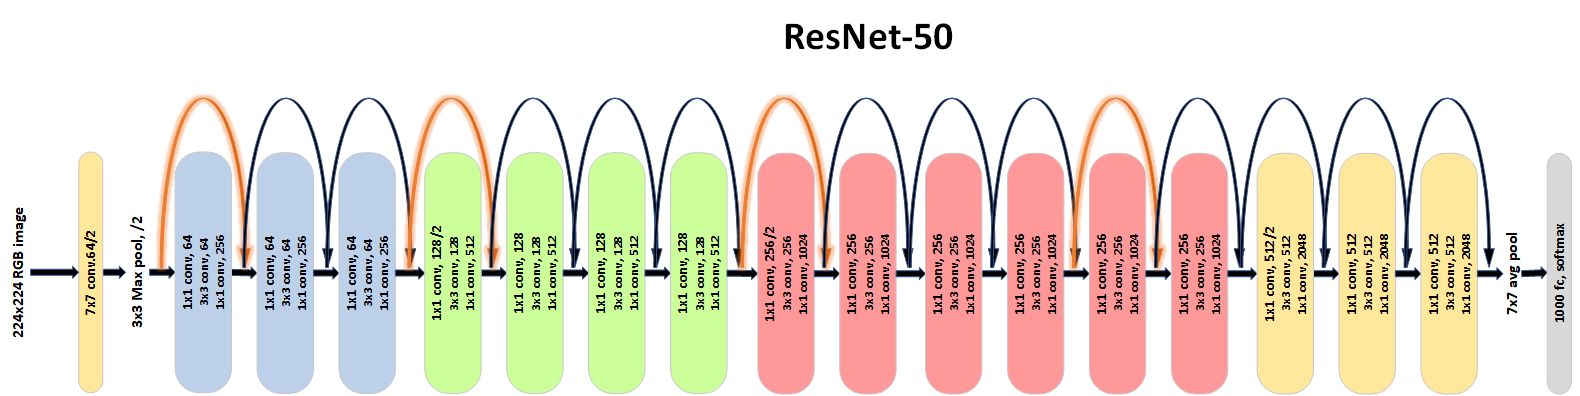
## About Notebook
In this notebook Medical Image classification is done using Pretrained ResNet_50 Model on ImageNet dataset. This simple Code is based on Keras API
CheXpert ~11GB dataset used in this notebook. CheXpert is a large dataset of chest x-rays images developed by stanfordML group.
### Why CheXpert
Chest radiography is the most common imaging examination globally, critical for screening, diagnosis, and management of many life threatening diseases. Automated chest radiograph interpretation at the level of practicing radiologists could provide substantial benefit in many medical settings, from improved workflow prioritization and clinical decision support to large-scale screening and global population health initiatives. For progress in both development and validation of automated algorithms, we realized there was a need for a labeled dataset that (1) was large, (2) had strong reference standards, and (3) provided expert human performance metrics for comparison.

CheXpert is a lagre chest x-ray dataset from Stanford ML group. It's a competition launched by the Stanford ML group aims at finding a prediction model which could perform as well as radiologist to find different pathologies. The Dataset available to train a model is composed of 223,414 chest radiographs of 65,240 patients.

Chest x-rays are labled as positive(1), Negative(0), uncertain(-1) or blank for unmentioned.
there different approaches to using the uncertainty labels (-1) or "u" during the model training.

- U-Ignore: We ignore the uncertain labels during training.
- U-Zeroes: We map all instances of the uncertain label to 0.
- U-Ones: We map all instances of the uncertain label to 1.
- U-SelfTrained: We first train a model using the U-Ignore approach to convergence, and then use the model to make predictions   that re-label each of the uncertainty labels with the probability prediction outputted by the model.
- U-MultiClass: We treat the uncertainty label as its own class.

### Working
This is a simple code you just have to download dataset from this link [CheXpert Dataset](https://stanfordmlgroup.github.io/competitions/chexpert/)
After downloading CheXpert-v1.0-small set working directory for CSV files (train.csv and valid.csv) paths.


### Import libraries

In [19]:
import tensorflow.keras # Framework for DL
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization # Layers for NN
from tensorflow.keras.layers import Conv2D, MaxPooling2D # Layers for NN
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications import ResNet50
from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D # Layers for NN
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model
#import missingno as msno # Tools for missing values

import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
from pathlib import Path

import matplotlib
matplotlib.use("Agg")

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

### Read CSV Files

In [3]:
dtrain=pd.read_csv("../input/chexpert/CheXpert-v1.0-small/train.csv")
dtrain = dtrain.fillna(0)

dnew=pd.read_csv("../input/chexpert/CheXpert-v1.0-small/valid.csv")
dnew = dnew.fillna(0)

#add dnew to dtrain to re-split since valid data in data set is very small
dtrain = dtrain.append(dnew)


## data preprocessing
- Only frontal images are considered in my project. I remove latteral images.
- Only x-ray images considered as input to the model. "Sex", "Age", "Frontal/Lateral", and "AP/PA" features were removed from training data
- Combined the downloaded validation data with train data as the validation data from the download link is very small comparing to the training data(200 images versus almost 200K images in training data)


In [4]:
#pre-process data: remove Lateral images we deal with only frontal images
dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]
#pre-process data: drop selected features - only images as inputs
dtrain = dtrain.drop(["Sex", "Age", "Frontal/Lateral", "AP/PA"], axis=1)

print(dtrain.shape)
dtrain.describe().transpose()

(191229, 15)


,count,mean,std,min,25%,50%,75%,max
No Finding,191229.0,0.088899,0.284598,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,191229.0,-0.005198,0.319927,-1.0,0.0,0.0,0.0,1.0
Cardiomegaly,191229.0,0.087560,0.387350,-1.0,0.0,0.0,0.0,1.0
Lung Opacity,191229.0,0.470101,0.543553,-1.0,0.0,0.0,1.0,1.0
Lung Lesion,191229.0,0.031026,0.204087,-1.0,0.0,0.0,0.0,1.0
Edema,191229.0,0.198186,0.531517,-1.0,0.0,0.0,1.0,1.0
Consolidation,191229.0,-0.059437,0.438206,-1.0,0.0,0.0,0.0,1.0
Pneumonia,191229.0,-0.059081,0.323371,-1.0,0.0,0.0,0.0,1.0
Atelectasis,191229.0,-0.000356,0.558545,-1.0,0.0,0.0,0.0,1.0
Pneumothorax,191229.0,0.078398,0.317135,-1.0,0.0,0.0,0.0,1.0


- Since this model is used as a first pass for chest x-ray diagnosis, false negative has higher cost and all uncertainties were consdiered as positive (replaced -1 by 1)
 - Data statistics show Lung Opacity, Edema, Atelectasis, Pleural Effusion and Support Devices have more balanced positive versus negative cases. The resut of observations have less than 25% of positive observations

In [5]:
# dealing with uncertanty (-1) values
dtrain = dtrain.replace(-1,1)
dtrain.describe().transpose()
print(dtrain.shape)

(191229, 15)


# ** Further Data Analysis **

In [6]:
features_size=[]
features_data =[]
features_name=[]
#print(list(dtrain.columns[1:15]))
for feature in list(dtrain.columns[1:15]):
    data_feature = dtrain.loc[dtrain[feature] == 1]
    features_size.append(data_feature.shape[0])
    features_data.append(data_feature)
    features_name.append(feature)
    
print(dtrain.shape)
print(list(dtrain.columns[1:15]))
#print(features_name)
#print(list(dtrain.columns))
print(features_size)
print(np.array(features_size)/dtrain.shape[0]*100)
#print(len(list(dtrain.columns[1:15])))
#print(len(features_data[0]))
#aa=features_data[0]
#print(features_data[0][0:2])


(191229, 15)
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
[17000, 19578, 30158, 98759, 8149, 61535, 37396, 20664, 59658, 20408, 86541, 4318, 7935, 108184]
[ 8.88986503 10.23798692 15.77062056 51.64436356  4.26138295 32.17869675
 19.55561134 10.80589241 31.19715106 10.6720215  45.25516527  2.25802572
  4.14947524 56.57300932]


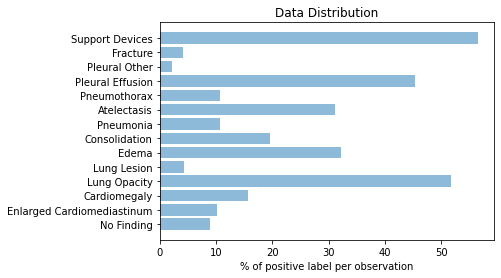

<Figure size 432x288 with 0 Axes>

In [7]:
%matplotlib inline
objects = list(dtrain.columns[1:15])
y_pos = np.arange(len(objects))
performance = np.array(features_size)/dtrain.shape[0]*100

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute.png', bbox_inches='tight')

The results indicate the unbalanced data issue for different observations. As you can see, the number of training data for Fracture, Pleural Other, and Lung Leison observations are very low comparing to for example the ones for Lung Opacity, Pleural Effusion or Support Device. Lets look at the correlation between observations to see if we can upsample the data for the observations with low training data. 

['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


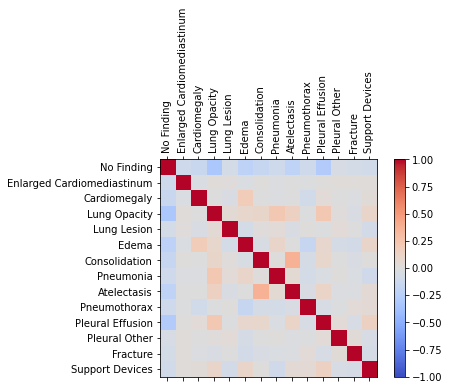

<Figure size 432x288 with 0 Axes>

In [8]:
#dtrain.corr(method='pearson')
#print(list(dtrain.columns[1:15]))
data = dtrain[list(dtrain.columns[1:15])]
print(list(dtrain.columns[1:15]))
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()
plt.savefig('Correlation.png', bbox_inches='tight')


The correlation matrix above indicates low correlation between Lung Leision, Fracture and Pleural Other (3 of classes with low data) with the other classes particularly the ones with high data such as Lung Opacity. This would enable us to upsample these observations to balance the data further. Although there are also other approaches to deal with unbalanced data such as weighted loss, the upsampling method has similar impact without changing the model structure or loss function. This approach is implemented here. 

In [9]:
dtrain_upsample=[]
dtrain_upsample_list=[]

dtrain_upsample_list = [features_data[0],features_data[0],features_data[0],features_data[0],
                       features_data[1],
                       features_data[2],
                       features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],features_data[4],
                       features_data[5],
                       features_data[6],
                       features_data[7],
                       features_data[8],
                       features_data[9],
                       features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],features_data[11],
                       features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12],features_data[12]]

dtrain_upsample = pd.concat(dtrain_upsample_list) 
print(dtrain_upsample.shape)
print(list(dtrain_upsample.columns[1:15]))

(497398, 15)
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


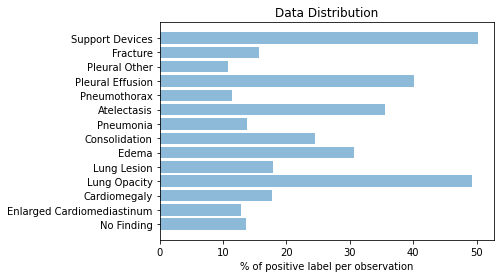

<Figure size 432x288 with 0 Axes>

In [10]:
features_sizeR=[]
features_dataR =[]
features_nameR=[]
#print(list(dtrain.columns[1:15]))
for featureR in list(dtrain_upsample.columns[1:15]):
    data_featureR = dtrain_upsample.loc[dtrain_upsample[featureR] == 1]
    features_sizeR.append(data_featureR.shape[0])
    features_dataR.append(data_featureR)
    features_nameR.append(featureR)

objectsR = list(dtrain_upsample.columns[1:15])
y_posR = np.arange(len(objectsR))
performanceR = np.array(features_sizeR)/dtrain_upsample.shape[0]*100

plt.barh(y_posR, performanceR, align='center', alpha=0.5)
plt.yticks(y_posR, objectsR)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute_balanced.png', bbox_inches='tight')

As it is observed above, the balance between observation is improved with this upsampling approach. However this increases the train data size and makes the training time slower. Now we split data to train/dev/test with 10% of data used for development and test

In [11]:
### split data into train/valid/test
#shuffle data 
dtrain_upsample = dtrain_upsample.sample(frac=1)
#split data
dvalid_size = round(0.1*dtrain_upsample.shape[0])
dtest_size = dvalid_size
dtr = dtrain_upsample[0:dtrain_upsample.shape[0]-dvalid_size-dtest_size+1]
dv = dtrain_upsample[dtrain_upsample.shape[0]-dvalid_size-dtest_size:dtrain_upsample.shape[0]-dvalid_size+1]
dte = dtrain_upsample[dtrain_upsample.shape[0]-dvalid_size:dtrain_upsample.shape[0]+1]
#Just for understanding
print(dtr.shape)
print(dv.shape)
print(dte.shape)
dtr.describe()
dv.describe()
dte.describe().transpose()

(397919, 15)
(49741, 15)
(49740, 15)


,count,mean,std,min,25%,50%,75%,max
No Finding,49740.0,0.134117,0.340782,0.0,0.0,0.0,0.0,1.0
Enlarged Cardiomediastinum,49740.0,0.129071,0.335282,0.0,0.0,0.0,0.0,1.0
Cardiomegaly,49740.0,0.178729,0.383129,0.0,0.0,0.0,0.0,1.0
Lung Opacity,49740.0,0.495235,0.499982,0.0,0.0,0.0,1.0,1.0
Lung Lesion,49740.0,0.181624,0.385539,0.0,0.0,0.0,0.0,1.0
Edema,49740.0,0.310434,0.462676,0.0,0.0,0.0,1.0,1.0
Consolidation,49740.0,0.241858,0.428213,0.0,0.0,0.0,0.0,1.0
Pneumonia,49740.0,0.138701,0.345638,0.0,0.0,0.0,0.0,1.0
Atelectasis,49740.0,0.355690,0.478727,0.0,0.0,0.0,1.0,1.0
Pneumothorax,49740.0,0.112988,0.316581,0.0,0.0,0.0,0.0,1.0


In [12]:
#In case you have to add path in csv file
dtr.Path = r'../input/chexpert/' + dtr.Path
dv.Path = r'../input/chexpert/' + dv.Path
dte.Path = r'../input/chexpert/' + dte.Path

dtr.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
146849,../input/chexpert/CheXpert-v1.0-small/train/pa...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
61584,../input/chexpert/CheXpert-v1.0-small/train/pa...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
41296,../input/chexpert/CheXpert-v1.0-small/train/pa...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
32217,../input/chexpert/CheXpert-v1.0-small/train/pa...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
135936,../input/chexpert/CheXpert-v1.0-small/train/pa...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


 - Image target size as input to the model are **224*224**
 - Batch size is set to **32** for training and validation set. 
 - For test set, shuffle is set to false to be able to compute F1 score later through prediction of test data. 

In [13]:
# data generation for Keras
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)

target_size = (224,224)
train_generator=train_datagen.flow_from_dataframe(dataframe=dtr, directory=None , x_col="Path", y_col=list(dtr.columns[1:15]), class_mode="other", target_size=target_size, batch_size=64)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dv, directory=None , x_col="Path", y_col=list(dv.columns[1:15]), class_mode="other", target_size=target_size, batch_size=64)
test_generator=test_datagen.flow_from_dataframe(dataframe=dte, directory=None , x_col="Path", y_col=list(dte.columns[1:15]), class_mode="other", target_size=target_size, shuffle = False, batch_size=1)


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 397918 validated image filenames.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 49739 validated image filenames.
Found 49739 validated image filenames.


- ResNet-50 is selected for CNN structure. A global average 2D pooling layer, a fully connected dense layer with 1024 nodes and Relu activation, and finally a fully connected dense layer with 14 nodes (representing 14 classes for chest x-ray observations) and sigmoid activation are added to modify DenseNet-121 architecture for our application. The weights are initialized with a network weights tuned for imagenet data. <font color=blue>All weights are tuned.</font>
- loss function is defined as binary cross entropy loss. 
- Adam optimizer selected with lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None.

### Model Design

In [14]:
# model architecture design/selection
# create the base pre-trained model
base_model = ResNet50(include_top = False, weights='imagenet')
image_size = 224

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(14, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

# model training
adam = tensorflow.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print(model.summary())



94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________________

In [15]:
# fit model
num_epochs = 2
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model_H = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
6217/6217 [==============================] - 3299s 530ms/step - loss: 0.5038 - accuracy: 0.1364 - val_loss: 0.4901 - val_accuracy: 0.1750
Epoch 2/2
6217/6217 [==============================] - 2364s 380ms/step - loss: 0.4888 - accuracy: 0.1335 - val_loss: 0.4835 - val_accuracy: 0.1887


### Plot Training

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()


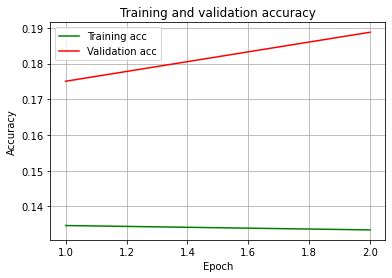

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


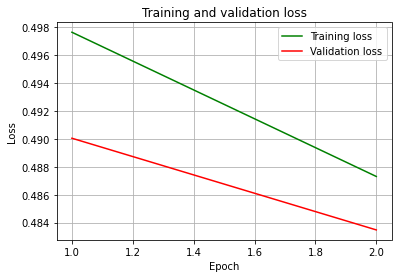

<Figure size 432x288 with 0 Axes>

In [16]:
print(model_H.history.keys())
#plot model Accuracy and loss on training and validation data
acc = model_H.history['accuracy']
val_acc = model_H.history['val_accuracy']
loss = model_H.history['loss']
val_loss = model_H.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', color='green', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='red',  label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('model accuracy.png', bbox_inches='tight')
plt.clf()
    
    
plt.plot(epochs, loss, 'b', color='green', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('model loss.png', bbox_inches='tight')
plt.clf()

In [ ]:
# save model
#model.save("ResNet_50.h5")

### Model Evaluation

In [21]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# prediction and performance assessment
test_generator.reset()
pred=model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:15],dtype=int)

#print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:15])))

score, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test score: 0.4840124845504761
Test accuracy: 0.1883029341697693
